In [233]:
import pandas as pd
import numpy as np

In [234]:
with open("tweets_AAPL.csv",'rb') as dfile:
    dstr = str(dfile.read())[1:5]

Open, High, Low, Close, Adj Close

In [235]:
%%time
with open("tweets_AAPL.csv",'rb') as dfile:
    dstr = str(dfile.read())[2:]
darr = dstr.split('\\r')
dmat = [rs.split(",") for rs in darr]
dmat = [r[:1] + [",".join(r[1:-5])] + r[-5:] for r in dmat]
dmat = [r for r in dmat if len(r) == 7]
df = pd.DataFrame(dmat)
df.columns = ["datestr","twt","open","high","low","close","adjclose"]
df["twtarr"] = df["twt"].apply(lambda text: text.lower().split())

CPU times: user 5.14 s, sys: 2.96 s, total: 8.1 s
Wall time: 10.6 s


In [236]:
from datetime import datetime

In [237]:
df = df[df["datestr"] != ""]
%time df["date"] = df["datestr"].apply( \
    lambda date: datetime.strptime(date,"%m/%d/%y"))
datedf = df[["date","open"]].groupby("date").aggregate(lambda gp: tuple(set(gp))[0])
pval = datedf.values.astype(float)
up = ((pval[1:] - pval[:-1]) > 0).astype(int)
datedf["openup"] = list(up.T[0]) + [0]

CPU times: user 5.23 s, sys: 374 ms, total: 5.6 s
Wall time: 8.08 s


In [238]:
%time df["openup"] = df["date"].apply(lambda date: price["openup"].loc[date])

CPU times: user 15.3 s, sys: 349 ms, total: 15.7 s
Wall time: 18.2 s


In [239]:
import gensim
%time w2vM = gensim.models.Word2Vec(df["twtarr"])

CPU times: user 57.5 s, sys: 1.1 s, total: 58.6 s
Wall time: 34.7 s


In [240]:
# number of samples to aggregate
Ns = int(1e6)

In [243]:
%%time
# MEAN AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).mean(axis=0)
#                  for twt in df["twtarr"][:Ns]])
# tvecs = np.array([np.array([w2vM[t]
#                             for t in twt
#                             if t in w2vM]).mean(axis=0)
#                  for twt in df["twt"][:Ns]])
# SUM AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).sum(axis=0)
#                  for twt in sentDf["SentimentText"][:Ns]])
# MEAN AGGREGATION
%time df["twtvecs"] = df["twtarr"][:Ns].apply(\
    lambda twt: np.array([w2vM[t] \
                         if t in w2vM else np.zeros((100,)) \
                         for t in twt]).mean(axis=0))

CPU times: user 28.3 s, sys: 917 ms, total: 29.2 s
Wall time: 37.6 s
CPU times: user 28.3 s, sys: 918 ms, total: 29.2 s
Wall time: 37.6 s


In [244]:
print(df.shape)
%time veclens = df["twtvecs"].apply(lambda vec: int(np.prod(vec.shape)))
df_empty = df[veclens != 100]
%time df = df[veclens == 100]
print(df.shape)

(221343, 11)
CPU times: user 2.98 s, sys: 169 ms, total: 3.15 s
Wall time: 3.73 s
CPU times: user 75.3 ms, sys: 9.22 ms, total: 84.5 ms
Wall time: 94.3 ms
(221343, 11)


In [250]:
dategps = df[["date","twtvecs"]].groupby("date")
datevecs = [np.mean(gp.values[:,1], axis=0) for k,gp in dategps]
datedf["datevecs"] = datevecs

In [251]:
import sklearn
from sklearn import ensemble,svm,neural_network,discriminant_analysis
from sklearn.metrics import roc_curve,auc,precision_recall_curve

from matplotlib import pyplot as plt
% matplotlib inline

def roc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_str = 'ROC (AUC Gain = %0.2f)' % (roc_auc - 0.5)
    plt.plot(fpr, tpr, lw=1,label=roc_str)
    plt.plot([0,1],[0,1],label="RAN CLF")
    plt.title(roc_str)
    plt.show()

def prrc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    pr, rc, thresholds = precision_recall_curve(y, probs[:, 1])
    roc_auc = auc(rc, pr)
    roc_str = 'Prec vs Recall (AUC Gain = %0.2f)' % (roc_auc - np.mean(y))
    plt.plot(rc,pr, lw=1,label=roc_str)
    plt.plot([0,1],[np.mean(y),np.mean(y)],label="RAN CLF")
    plt.axis([0,1,0,1])
    plt.title(roc_str)
    plt.show()

def evaluate(clf,X,y):
    yhat = clf.predict(X)
    accu = np.mean(yhat == y)
    prec = np.mean(y[yhat == 1])
    recl = np.mean(yhat[y == 1])
    f1 = 2 * prec * recl / (prec + recl)
    print("Accuracy",accu,"Precision",prec,"Recall",recl,"F1",f1)

# Average of tweets in a day

In [272]:
# dvecs = np.array([vec.T for vec in avgvecs["vecs"].values])
X = np.array([vec.T for vec in datedf["datevecs"].values])
y = datedf["openup"].values
# inverse classifier
# y = 1 - y

In [273]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(X.shape[0]) < ratio
pidx = ~tidx

CPU times: user 40.5 ms, sys: 1.87 ms, total: 42.4 ms
Wall time: 73.3 ms
TEST
Accuracy 0.454545454545 Precision 0.444444444444 Recall 0.8 F1 0.571428571429
CPU times: user 2.75 ms, sys: 746 µs, total: 3.49 ms
Wall time: 3.12 ms
TRAIN
Accuracy 0.875647668394 Precision 0.835820895522 Recall 0.982456140351 F1 0.903225806452
CPU times: user 3.99 ms, sys: 526 µs, total: 4.51 ms
Wall time: 6.79 ms
ROC AUC


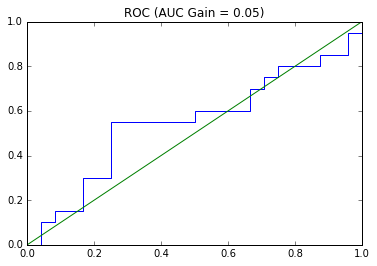

CPU times: user 219 ms, sys: 10.8 ms, total: 230 ms
Wall time: 279 ms
PRECISION/RECALL AUC


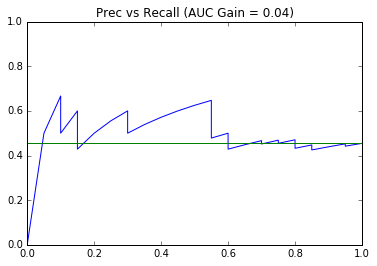

CPU times: user 266 ms, sys: 15.2 ms, total: 281 ms
Wall time: 473 ms


In [281]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
clf = rf
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 23.4 ms, sys: 7.76 ms, total: 31.2 ms
Wall time: 31.5 ms
TEST
Accuracy 0.518518518519 Precision 0.518518518519 Recall 1.0 F1 0.682926829268
CPU times: user 2.08 ms, sys: 855 µs, total: 2.93 ms
Wall time: 2.38 ms
TRAIN
Accuracy 0.579234972678 Precision 0.579234972678 Recall 1.0 F1 0.733564013841
CPU times: user 2.21 ms, sys: 551 µs, total: 2.76 ms
Wall time: 2.4 ms
ROC AUC


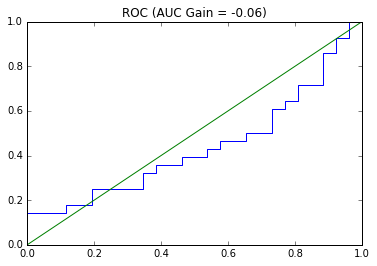

CPU times: user 226 ms, sys: 16.8 ms, total: 243 ms
Wall time: 243 ms
PRECISION/RECALL AUC


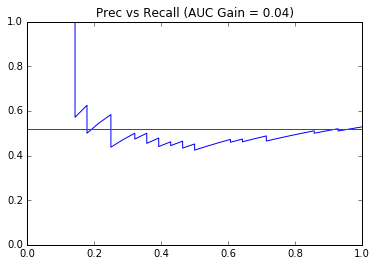

CPU times: user 241 ms, sys: 8.45 ms, total: 250 ms
Wall time: 304 ms


In [261]:
mlp = sklearn.neural_network.MLPClassifier()
clf = mlp
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 9.59 ms, sys: 3.78 ms, total: 13.4 ms
Wall time: 12.7 ms
TEST
Accuracy 0.518518518519 Precision 0.518518518519 Recall 1.0 F1 0.682926829268
CPU times: user 2.58 ms, sys: 1.11 ms, total: 3.69 ms
Wall time: 3.29 ms
TRAIN
Accuracy 1.0 Precision 1.0 Recall 1.0 F1 1.0
CPU times: user 2.8 ms, sys: 949 µs, total: 3.74 ms
Wall time: 3.13 ms
ROC AUC


/Users/aduriseti/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


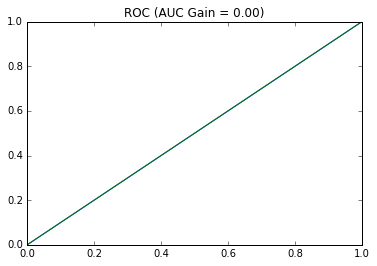

CPU times: user 226 ms, sys: 8.92 ms, total: 235 ms
Wall time: 281 ms
PRECISION/RECALL AUC


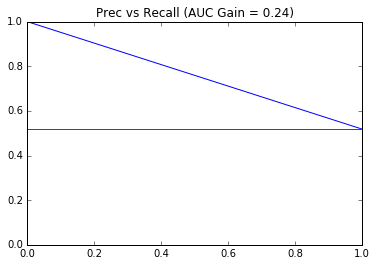

CPU times: user 226 ms, sys: 7.82 ms, total: 233 ms
Wall time: 293 ms


In [262]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
clf = qda
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

# Single tweets

In [263]:
# number of samples to train on
N = int(1e6)
X = np.array([x.T for x in df["twtvecs"][:N].values])
y = df["openup"][:N].values
# inverse classifier
# y = 1 - y

In [267]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(min(X.shape[0],N)) < ratio
pidx = ~tidx

CPU times: user 14.7 s, sys: 508 ms, total: 15.2 s
Wall time: 24.1 s
TEST
Accuracy 0.572322373011 Precision 0.568659387043 Recall 0.991996478451 F1 0.72291159359
CPU times: user 85.7 ms, sys: 27.7 ms, total: 113 ms
Wall time: 117 ms
TRAIN
Accuracy 0.576078231869 Precision 0.571613029669 Recall 0.993199322937 F1 0.725615021001
CPU times: user 345 ms, sys: 120 ms, total: 465 ms
Wall time: 526 ms
ROC AUC


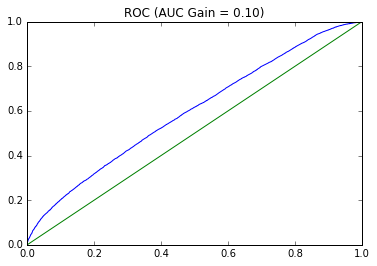

CPU times: user 323 ms, sys: 47 ms, total: 370 ms
Wall time: 480 ms
PRECISION/RECALL AUC


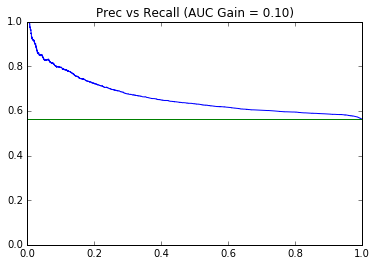

CPU times: user 377 ms, sys: 32.6 ms, total: 410 ms
Wall time: 625 ms


In [268]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
clf = rf
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 2min 59s, sys: 19.8 s, total: 3min 19s
Wall time: 4min 12s
TEST
Accuracy 0.704813989602 Precision 0.711150631336 Recall 0.800112049302 F1 0.75301295571
CPU times: user 163 ms, sys: 189 ms, total: 352 ms
Wall time: 347 ms
TRAIN
Accuracy 0.748798824261 Precision 0.746496293858 Recall 0.840239175506 F1 0.790598612786
CPU times: user 601 ms, sys: 310 ms, total: 911 ms
Wall time: 1.2 s
ROC AUC


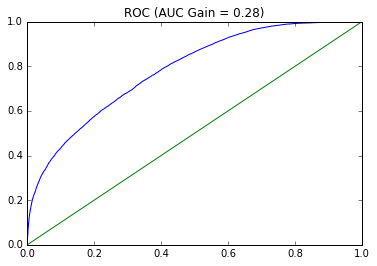

CPU times: user 396 ms, sys: 101 ms, total: 496 ms
Wall time: 546 ms
PRECISION/RECALL AUC


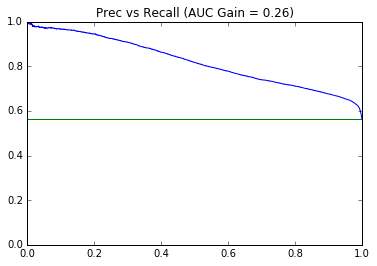

CPU times: user 364 ms, sys: 48.9 ms, total: 413 ms
Wall time: 468 ms


In [269]:
mlp = sklearn.neural_network.MLPClassifier()
clf = mlp
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 6.02 s, sys: 672 ms, total: 6.69 s
Wall time: 8.11 s
TEST
Accuracy 0.60288524295 Precision 0.655950055211 Recall 0.618071951659 F1 0.636447924178
CPU times: user 244 ms, sys: 167 ms, total: 411 ms
Wall time: 550 ms
TRAIN
Accuracy 0.613385337177 Precision 0.667305093583 Recall 0.628126158068 F1 0.647123163282
CPU times: user 1.08 s, sys: 844 ms, total: 1.92 s
Wall time: 2.97 s
ROC AUC


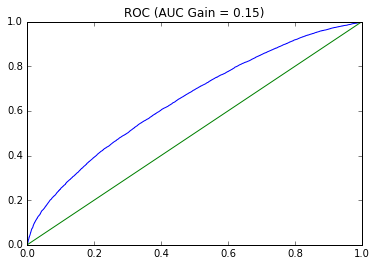

CPU times: user 550 ms, sys: 139 ms, total: 688 ms
Wall time: 1.07 s
PRECISION/RECALL AUC


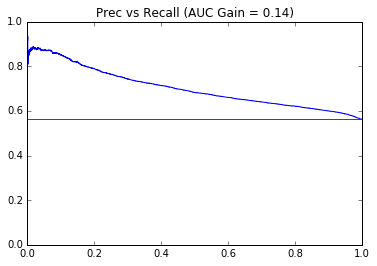

CPU times: user 527 ms, sys: 143 ms, total: 670 ms
Wall time: 915 ms


In [270]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
clf = qda
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])